In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../docs/two_stage_detection_results.csv')
print(f"Transactions: {len(df)}, Fraud: {df['target'].sum()} ({df['target'].mean()*100:.2f}%)")

Transactions: 13140, Fraud: 165 (1.26%)


In [4]:
# fraud vs legit comparison
def compare(col):
    legit = df[df['target'] == 0][col].dropna()
    fraud = df[df['target'] == 1][col].dropna()
    stat, p = stats.mannwhitneyu(legit, fraud, alternative='two-sided')
    return {'feature': col, 'legit_mean': legit.mean(), 'fraud_mean': fraud.mean(), 
            'ratio': fraud.mean() / legit.mean() if legit.mean() > 0 else 0, 'p_value': p}

cols = ['logins_last_7_days', 'logins_last_30_days', 'monthly_phone_model_changes',
        'avg_login_interval_30d', 'std_login_interval_30d', 'burstiness_login_interval', 'amount']
cols = [c for c in cols if c in df.columns]

results = pd.DataFrame([compare(c) for c in cols])
results['significant'] = results['p_value'] < 0.05
print(results.to_string(index=False))

                    feature    legit_mean    fraud_mean    ratio      p_value  significant
         logins_last_7_days     11.765395      9.678788 0.822649 7.646087e-04         True
        logins_last_30_days     43.680771     33.042424 0.756452 8.218188e-06         True
monthly_phone_model_changes      1.281156      1.139394 0.889348 1.361475e-03         True
     avg_login_interval_30d  97385.369588 145238.982239 1.491384 7.735304e-01        False
     std_login_interval_30d 137384.329003 158454.057350 1.153363 3.053803e-01        False
  burstiness_login_interval      0.178233      0.154802 0.868538 6.196645e-01        False
                     amount  48051.947095 224649.420439 4.675137 9.312201e-46         True


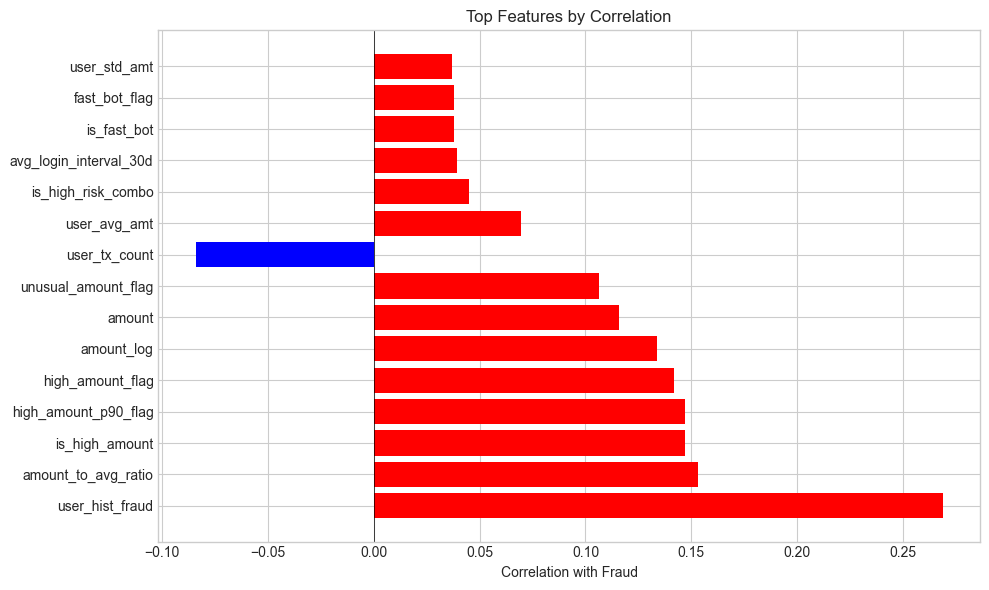

In [5]:
# correlation with target
numeric = df.select_dtypes(include=[np.number]).columns
numeric = [c for c in numeric if c not in ['target', 'fraud_prediction', 'fraud_probability', 'scorecard_total']]

corr = [(c, df[c].corr(df['target'])) for c in numeric]
corr = sorted(corr, key=lambda x: abs(x[1]), reverse=True)[:15]

fig, ax = plt.subplots(figsize=(10, 6))
names, vals = zip(*corr)
colors = ['red' if v > 0 else 'blue' for v in vals]
ax.barh(names, vals, color=colors)
ax.axvline(0, color='black', lw=0.5)
ax.set_xlabel('Correlation with Fraud')
ax.set_title('Top Features by Correlation')
plt.tight_layout()
plt.show()

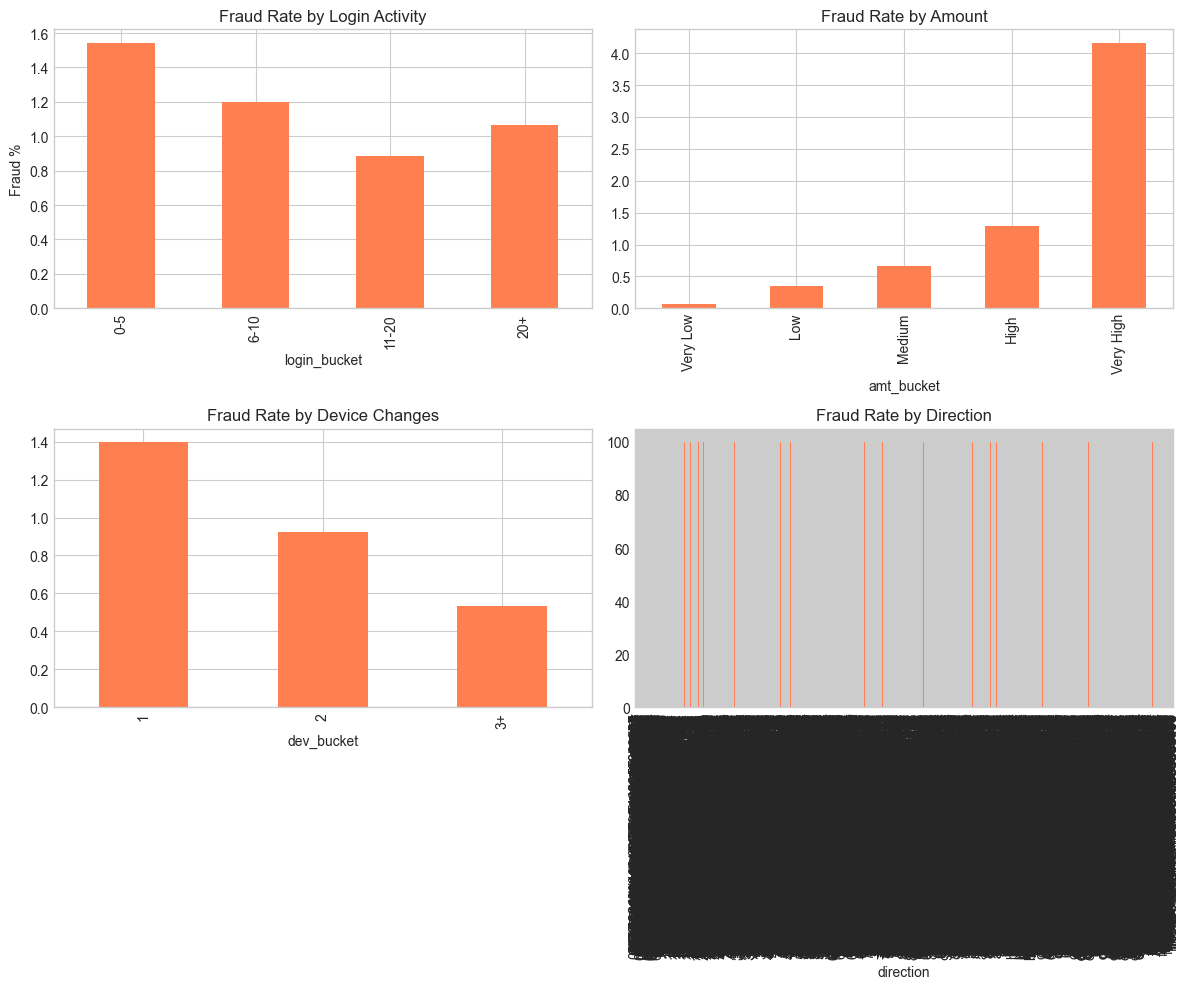

In [30]:
# fraud rate by feature buckets
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# logins
if 'logins_last_7_days' in df.columns:
    df['login_bucket'] = pd.cut(df['logins_last_7_days'], bins=[0, 5, 10, 20, 100], labels=['0-5', '6-10', '11-20', '20+'])
    rate = df.groupby('login_bucket')['target'].mean() * 100
    rate.plot(kind='bar', ax=axes[0,0], color='coral')
    axes[0,0].set_title('Fraud Rate by Login Activity')
    axes[0,0].set_ylabel('Fraud %')

# amount
if 'amount' in df.columns:
    df['amt_bucket'] = pd.qcut(df['amount'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')
    rate = df.groupby('amt_bucket')['target'].mean() * 100
    rate.plot(kind='bar', ax=axes[0,1], color='coral')
    axes[0,1].set_title('Fraud Rate by Amount')

# device changes
if 'monthly_phone_model_changes' in df.columns:
    df['dev_bucket'] = pd.cut(df['monthly_phone_model_changes'], bins=[-1, 1, 2, 100], labels=['1', '2', '3+'])
    rate = df.groupby('dev_bucket')['target'].mean() * 100
    rate.plot(kind='bar', ax=axes[1,0], color='coral')
    axes[1,0].set_title('Fraud Rate by Device Changes')

# direction
if 'direction' in df.columns:
    rate = df.groupby('direction')['target'].mean() * 100
    rate.plot(kind='bar', ax=axes[1,1], color='coral')
    axes[1,1].set_title('Fraud Rate by Direction')

plt.tight_layout()
plt.show()

In [31]:
# feature rationale
rationale = {
    'logins_last_7_days': 'activity spike = account takeover',
    'monthly_phone_model_changes': 'device hopping = fraud evasion', 
    'burstiness_login_interval': 'irregular patterns = bot or new user',
    'amount': 'high amounts = higher risk',
    'direction': 'outgoing transfers = higher risk',
    'avg_login_interval_30d': 'regular intervals = automation',
    'is_device_hopper': 'frequent device changes flag',
    'is_high_amount': 'above 90th percentile flag',
}

print("FEATURE RATIONALE")
print("=" * 60)
for f, r in rationale.items():
    print(f"{f:30} | {r}")

FEATURE RATIONALE
logins_last_7_days             | activity spike = account takeover
monthly_phone_model_changes    | device hopping = fraud evasion
burstiness_login_interval      | irregular patterns = bot or new user
amount                         | high amounts = higher risk
direction                      | outgoing transfers = higher risk
avg_login_interval_30d         | regular intervals = automation
is_device_hopper               | frequent device changes flag
is_high_amount                 | above 90th percentile flag
